# Reproducability Report - Lars Christiansen

## Code Repository:

The paper provides a [code basis](https://github.com/Chen-Cai-OSU/MPNN-GT-Connection) to run all experiments, which is largely based on the existing [GraphGPS](https://github.com/rampasek/GraphGPS) repo. The authors changes are minor dataset adjustments by providing virtual nodes on the datasets.

## Challenges:

Following the authors' instructions, I encountered several challenges. One involved dependency issues between PyTorch and PyTorch-Geometric. This hurdle was overcome by installing all available packages using the conda package solver instead of pip.

There were also some code-related issues that might not be present in older library versions. Due to limited documentation for PyTorch-Geometric, pinpointing the exact cause of these errors proved difficult. One example involved a duplicate optimizer configuration, which seemed to be specific to the used PyTorch-Geometric version (similar to this reported Issue](https://github.com/rampasek/GraphGPS/issues/50)). Fortunately, most of these problems were resolved through minor adjustments to the code, guided by the error messages themselves.

## Install packages:

Its recommended to create a new jupyter kernel as described in the Readme.md

In [ ]:
%conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
%conda install pyg -c pyg 
%conda install lightning -c conda-forge
%conda install yacs ogb pandas scikit-learn performer-pytorch wandb
%conda install openbabel fsspec rdkit -c conda-forge

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.2.2
12.1


In [ ]:
%pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.2+cu121.html
%conda install -c dglteam/label/th22_cu121 dgl

## Main Results of the paper

Recent advances in Graph Transformers (GTs) are explored in this paper, comparing them to the well-established Message Passing Neural Networks (MPNNs). GTs have demonstrated the ability to both outperform and approximate MPNNs. A key challenge in Graph Neural Networks (GNNs) is oversmoothing, where features across nodes become increasingly similar with deeper layers. This paper proposes a novel approach using Virtual Nodes (VNs) to mitigate this issue. VNs function like regular nodes but connect to all others, acting as a central hub for global information. Theoretically, the paper proves that VNs can simulate specific forms of Graph Transformers. Experiments further suggest that VNs may be a promising way to enhance overall model performance.

The following graph shows the first experiment of the paper. Covering the performance gains by adding a VN for graph classification tasks (peptides-func) and graph regression (peptides-struct). This shows the overall performance in long range interaction modeling tasks.
![Experiment 1](resources/results1.png)

![Virtual Nodes vs Transformer Multihead-attention](resources/vn-transformer.png) <br>                                                             Virtual Node connected to all other nodes in the graph vs the simplified multihead attention mechanism in transformers.

## Setup:

### Data:

The data originates from the Long Range Graph Benchmark (LRGB). This benchmark provides two particularly relevant datasets for our study: Peptides-func and Peptides-struct. Both datasets focus on chemical compounds and their structures, represented as graphs. Importantly, achieving strong performance on these tasks necessitates long-range reasoning capabilities within the model.

### Models:

This section explores the performance of various graph neural network architectures on tasks requiring long-range reasoning. The analysis utilizes several established models, including GCN, GINE, GatedGCN variants, Transformer with RWSE, and Spectral Attention Network (SAN) with different pre-processing techniques (LapPE and RWSE). The results (presented in a separate table) indicate that Transformer models generally achieve superior performance on both graph regression and graph classification compared to models without virtual nodes. Notably, all models exhibit a relatively small and comparable parameter footprint.

## Reproduce Results:

To run all models as an interactive bash job run following commands. Note that this takes roughly 24 hours to train all models.

In [1]:
%cd experiment1

/home/schwollie/Desktop/paper-20/experiment1


/home/schwollie/anaconda3/envs/paper/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
!cat runAll.sh 
!chmod +x runAll.sh
!bash -i ./runAll.sh

Prepare results for generating plot:
Use path "experiment1/results_pre_trained/" for pretrained variant

In [3]:
%cd ..

/home/schwollie/Desktop/paper-20


In [1]:
from experiment1.results_processing import *

results_folder = "experiment1/results_pre_trained/"

json_results = get_stats_json_paths(results_folder)
print("model count: " + str(len(json_results)))

# Now find the best stat for each model.
best_stats = find_best_stat(json_results)

# generate tables:
table_func = generate_table("peptides-func", best_stats)
table_struct = generate_table("peptides-struct", best_stats)

model count: 30
4
4
4
4


#### create the plot:

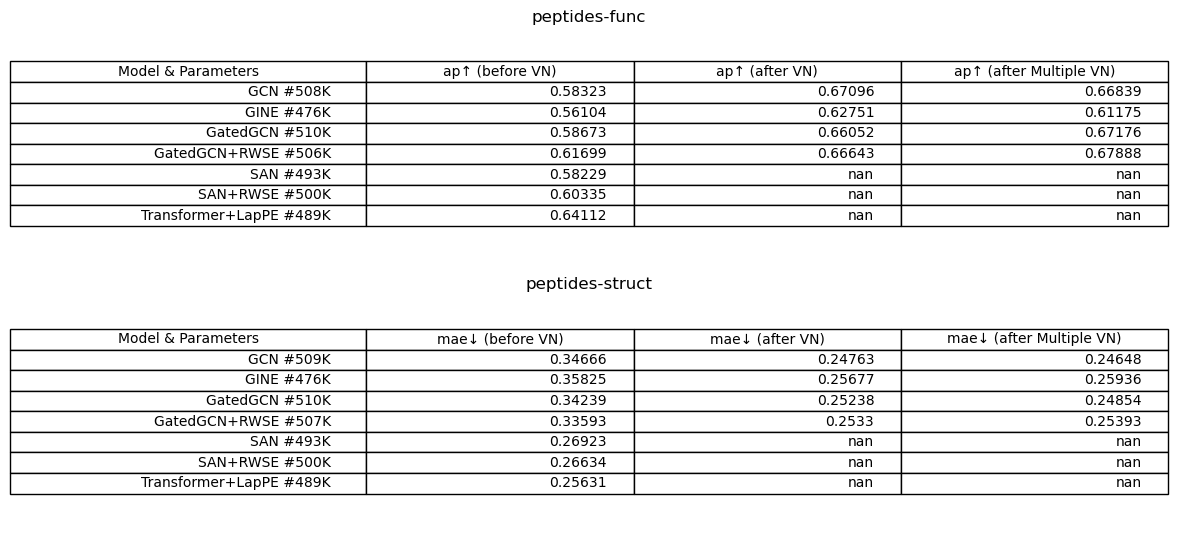

In [7]:
# Create a figure and an axis

fig, ax = plt.subplots(2, 1, figsize=(12, 5.5)) 

def plot_table(pos, data, name):
    cellText = data.values.tolist()  
    colLabels = data.columns.tolist()
    
    ax[pos].table(cellText=cellText, colLabels=colLabels, loc='center', colWidths=[0.4, 0.3, 0.3, 0.3])
    ax[pos].set_title(name, pad=2)
    ax[pos].axis('off')

plot_table(0, table_func, "peptides-func")
plot_table(1, table_struct, "peptides-struct")
plt.tight_layout()
plt.show()

Comparing my results to the paper's tables reveals a high degree of similarity. While some of my models appear to have performed slightly worse (probably due to too few epochs in trainging time) the key finding remains consistent: the inclusion of virtual nodes demonstrably improves the performance of all models.

## Possible Extensions

Building upon the findings of this [paper](https://openreview.net/pdf?id=dI6KBKNRp7), it's possible that a single virtual node may not be sufficient for very large graphs. Exploring the use of multiple virtual nodes within the model architecture seems to be promising. This approach could potentially improve the model's ability to capture long-range dependencies in exceptionally large graphs.